# Import files

In [37]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, roc_curve

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
import tensorflow.keras.backend as K
K.clear_session()


# Hyperparameters

In [39]:
num_classes = 10
batch_size = 256
epochs = 100

# Image Resolution

In [40]:
img_rows, img_cols = 28, 28

# Loading the data.


In [41]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=10000, random_state=42)

# Preparing the data

In [42]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [43]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')
x_val /= 255
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (50000, 28, 28, 1)
50000 train samples
10000 test samples


In [44]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Creating the Model 

## Model

In [45]:
model = Sequential()

model.add(Input(shape=input_shape))

# Convolutional layers
model.add(Conv2D(16, 3, activation='relu'))
model.add(Conv2D(16, 3, activation='relu'))
model.add(Conv2D(16, 3, activation='relu'))
model.add(MaxPooling2D())

model.add(SeparableConv2D(32, 3, activation='relu', padding='same'))
model.add(SeparableConv2D(32, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(SeparableConv2D(64, 3, activation='relu', padding='same'))
model.add(SeparableConv2D(64, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(SeparableConv2D(128, 3, activation='relu', padding='same'))
model.add(SeparableConv2D(128, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Dropout(0.2))

model.add(SeparableConv2D(256, 3, activation='relu', padding='same'))
model.add(SeparableConv2D(256, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(BatchNormalization())

model.add(Dropout(0.2))

model.add(SeparableConv2D(256, 3, activation='relu', padding='same'))
model.add(SeparableConv2D(256, 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(BatchNormalization())
   
model.add(Flatten())

model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
          
model.add(Dense(units=64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
          
model.add(Dense(units=10, activation='sigmoid'))


# Compile the model
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')
])


## Print the model summary


In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 16)       0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 11, 11, 32)       688       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 11, 11, 32)       1

## Image Generator

In [47]:
# datagen = ImageDataGenerator(
#     featurewise_center=False,  # Ne pas centrer les données par rapport à la moyenne de l'ensemble du dataset
#     samplewise_center=False,   # Ne pas centrer les données par rapport à la moyenne de chaque échantillon
#     featurewise_std_normalization=False,  # Ne pas normaliser les données en les divisant par l'écart type de l'ensemble du dataset
#     samplewise_std_normalization=False,   # Ne pas normaliser les données en les divisant par l'écart type de chaque échantillon
#     zca_whitening=False,  # Ne pas appliquer le blanchiment ZCA (décorrélation des features)
# #     zca_epsilon=1e-06,  # Valeur d'épison pour la stabilisation du blanchiment ZCA (non utilisée dans ce cas)
# #    rotation_range=0,  # Aucune rotation aléatoire des images
# #    width_shift_range=0.1,  # Décalage horizontal aléatoire des images de 10% de la largeur totale
# #    height_shift_range=0.1,  # Décalage vertical aléatoire des images de 10% de la hauteur totale
# #     brightness_range=None,  # Pas de modification aléatoire de la luminosité des images
# #     shear_range=0.0,  # Pas de cisaillement aléatoire des images
#     zoom_range=0.1,  # Zoom aléatoire des images de 10%
# #     channel_shift_range=0.0,  # Pas de décalage aléatoire des canaux de couleur des images
# #     fill_mode='nearest',  # Mode de remplissage pour les pixels nouvellement créés lors des transformations (non utilisé dans ce cas)
# #     cval=0.0,  # Valeur de remplissage pour les pixels nouvellement créés lors des transformations (non utilisé dans ce cas)
# #    horizontal_flip=True,   # Retournement horizontal aléatoire des images
# #    vertical_flip=False,    # Pas de retournement vertical aléatoire des images
# #     rescale=None,  # Pas de redimensionnement des valeurs des pixels (non utilisé dans ce cas)
# #     preprocessing_function=None,  # Fonction de prétraitement supplémentaire à appliquer aux images (non utilisée dans ce cas)
# #     data_format=None,  # Format des données (non spécifié dans ce cas)
# #     validation_split=0.0,  # Fraction des données à utiliser pour la validation (non utilisée dans ce cas)
# #     interpolation_order=1,  # Ordre d'interpolation pour les transformations (non spécifié dans ce cas)
# #     dtype=None  # Type de données pour les images (non spécifié dans ce cas)
# )

# datagen.fit(x_train)
# datagen_train = datagen.flow(x_train, y_train, batch_size=batch_size)
# datagen_val= datagen.flow(x_test, y_test, batch_size=batch_size)

## Callbacks

In [48]:
def exponential_decay(lr, s):
    def exponential_decay_fn(epoch):
        return lr * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 12)

In [49]:
learning_rate_scheduler = LearningRateScheduler(exponential_decay_fn)


In [50]:
checkpoint = ModelCheckpoint("mnist_model.h5", monitor="val_loss", verbose=1, save_best_only=True)

In [51]:
"""Stop training when a monitored metric has stopped improving"""
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=15,
    verbose=2,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)

## Training the model

In [52]:
history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[learning_rate_scheduler, checkpoint, early_stopping],
                    # validation_split=0.0,
                    validation_data=(x_val, y_val),
                    shuffle=True,
                    # class_weight=class_weight,
                    # sample_weight=None,
                    # initial_epoch=0,
                    steps_per_epoch=len(x_train)//batch_size,
                    validation_steps=len(x_val)//batch_size,
                    # validation_batch_size=None,
                    # validation_freq=1,
                    # max_queue_size=10,
                    # workers=1,
                    # use_multiprocessing=False
)

Epoch 1/100
195/195 [==============================] - ETA: 0s - loss: 0.2178 - accuracy: 0.5727 - precision: 0.5769 - recall: 0.4254
Epoch 1: val_loss improved from inf to 0.41797, saving model to mnist_model.h5
195/195 [==============================] - 85s 400ms/step - loss: 0.2178 - accuracy: 0.5727 - precision: 0.5769 - recall: 0.4254 - val_loss: 0.4180 - val_accuracy: 0.0980 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 2/100
195/195 [==============================] - ETA: 0s - loss: 0.0492 - accuracy: 0.9390 - precision: 0.9422 - recall: 0.9211
Epoch 2: val_loss improved from 0.41797 to 0.17024, saving model to mnist_model.h5
195/195 [==============================] - 40s 208ms/step - loss: 0.0492 - accuracy: 0.9390 - precision: 0.9422 - recall: 0.9211 - val_loss: 0.1702 - val_accuracy: 0.6641 - val_precision: 0.6966 - val_recall: 0.5752 - lr: 0.0083
Epoch 3/100
195/195 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9661 - preci

# Evaluate the model

In [53]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.00714594591408968
Test accuracy: 0.9932000041007996


In [54]:
predict_out = model.predict(x_test)
predicted_labels = np.argmax(predict_out, axis=1)
predicted_labels_binary = np.zeros_like(predict_out)  
print(predicted_labels_binary, '\n', y_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 
 [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [55]:
for i in range(len(predicted_labels)):
    predicted_labels_binary[i, predicted_labels[i]] = 1

In [56]:
accuracy = accuracy_score(y_test, predicted_labels_binary)
precision = precision_score(y_test, predicted_labels_binary, average='macro')
recall = recall_score(y_test, predicted_labels_binary, average='macro')


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print(f'F1 score : {(2*precision*recall)/(precision +  recall)}')

Accuracy: 0.9932
Precision: 0.9932198731179633
Recall: 0.9930453136753279
F1 score : 0.99313258572622


In [57]:
classification = classification_report(y_test, predicted_labels_binary, target_names=['0','1','2','3','4', '5', '6', '7', '8', '9'])
print(classification)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

   micro avg       0.99      0.99      0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000
 samples avg       0.99      0.99      0.99     10000



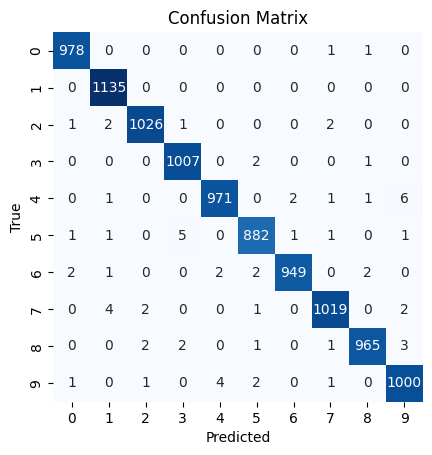

In [58]:
predicted_classes = np.argmax(predicted_labels_binary, axis=1)
true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', cbar=False, square=True,  fmt='d',
             xticklabels=['0','1','2','3','4','5','6','7','8','9'], yticklabels=['0','1','2','3','4','5','6','7','8','9'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [59]:
from keras.models import load_model

# Chargez le modèle depuis le fichier .h5
model = load_model('models\mnist_model.h5')

# Convertissez le modèle en format JSON
model_json = model.to_json()

# Enregistrez le modèle au format JSON dans un fichier
with open('models\model.json', 'w') as json_file:
    json_file.write(model_json)